In [4]:
# imports


#import json
#import tensorflow
#import concurrent.futures
#from datasets import load_dataset
#from resnet import ResNet152, ResNet50


from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from transformers import AutoImageProcessor, ResNetForImageClassification
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
import torch_directml as dml
import torch.optim as optim
import math
import copy
import os
import cv2
import time
import shutil
import random
import psutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
def analyze_image_filenames(image_dir, sample_size=500):
    """Analyze image filename patterns to understand their structure"""
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print("No image files found in directory!")
        return []

    sample = random.sample(image_files, min(sample_size, len(image_files)))
    
    print(f"\nAnalyzing {len(sample)} sample image filenames:")
    for filename in sample:
        print(f"  - {filename}")
    
    # Try to identify patterns
    separators = ['_', '-', ' ']
    for sep in separators:
        has_separator = any(sep in filename for filename in sample)
        if has_separator:
            print(f"\nFound separator '{sep}' in filenames")
            parts_counts = [len(f.split(sep)) for f in sample if sep in f]
            if parts_counts:
                print(f"  Average parts when split by '{sep}': {sum(parts_counts)/len(parts_counts):.1f}")
    
    return image_files

# Run the analysis
image_files = analyze_image_filenames("./images/cars")


Analyzing 500 sample image filenames:
  - 04108.jpg
  - 2WATA2TTUQ8B.jpg
  - hyt8xz5w7jxv.jpg
  - Lincoln_Navigator_2015_61_20_380_35_6_78_78_207_16_RWD_7_4_SUV_Kbe.jpg
  - Acura_RDX_2015_36_18_270_35_6_73_66_183_19_AWD_5_4_SUV_qcb.jpg
  - Image_006558.jpg
  - YXVPRYOY05SG.jpg
  - Dodge_Grand Caravan_2011_28_17_280_36_6_78_67_202_17_FWD_7_4_Van_ukY.jpg
  - Chevrolet_TrailBlazer_2005_28_17_270_42_6_74_75_nan_15_RWD_7_4_SUV_FnZ.jpg
  - XGUJQ9TAZTVC.jpg
  - 4hidch4juza2.jpg
  - BMW_7-Series_2019_91_18_320_20_4_74_58_206_nan_AWD_5_4_4dr_hXm.jpg
  - Volkswagen_Jetta_2020_23_17_140_14_4_70_57_185_nan_FWD_5_4_4dr_FBN.jpg
  - vb0w0ncvu2l1.jpg
  - Land Rover_Range Rover Evoque_2019_65_20_280_20_4_74_64_172_21_4WD_5_4_SUV_zUo.jpg
  - GMC_Terrain_2019_39_19_250_20_4_72_65_182_21_AWD_5_4_SUV_XQU.jpg
  - Audi_A3_2019_38_17_180_20_4_70_55_174_26_FWD_4_2_Convertible_BPP.jpg
  - Mercedes-Benz_E Class_2017_72_19_390_30_6_73_57_194_18_AWD_5_4_4dr_ZSb.jpg
  - Nissan_Maxima_2011_31_18_290_35_6_73_57_190_

In [6]:
# Load combined_cars.csv
csv_path = './processed_data/combined_cars.csv'
combined_cars_df = pd.read_csv(csv_path)

# Create class labels from Make and Model
combined_cars_df['Class'] = combined_cars_df['Make'] # + ' ' + combined_cars_df['Model']
class_names = combined_cars_df['Class'].unique().tolist()
class_names.append('other')  # Add 'other' for non-car images
print(f"Class names: {class_names}")
len(class_names)


Class names: ['Maruti', 'Hyundai', 'Datsun', 'Honda', 'Tata', 'Chevrolet', 'Toyota', 'Jaguar', 'Mercedes-Benz', 'Audi', 'Skoda', 'Jeep', 'BMW', 'Mahindra', 'Ford', 'Nissan', 'Renault', 'Fiat', 'Volkswagen', 'Volvo', 'Mitsubishi', 'Land', 'Daewoo', 'MG', 'Force', 'Isuzu', 'OpelCorsa', 'Ambassador', 'Kia', 'Dodge', 'GMC', 'AM General', 'Lamborghini', 'Import Trade Services', 'Acura', 'Buick', 'Morgan', 'Mercury', 'Suzuki', 'Mazda', 'MINI', 'Chrysler', 'Infiniti', 'Subaru', 'Lexus', 'Saab', 'Porsche', 'Peugeot', 'Pontiac', 'Merkur', 'Ram', 'Land Rover', 'Aston Martin', 'Bentley', 'Cadillac', 'Lotus', 'Plymouth', 'Ferrari', 'Lincoln', 'Oldsmobile', 'Saturn', 'Hummer', 'Roush Performance', 'Maybach', 'Saleen Performance', 'Rolls-Royce', 'Maserati', 'Eagle', 'Geo', 'Alfa Romeo', 'Dabryan Coach Builders Inc', 'Tesla', 'Genesis', 'Bugatti', 'Yugo', 'McLaren Automotive', 'Rivian', 'Evans Automobiles', 'Daihatsu', 'Lucid', 'Wallace Environmental', 'CX Automotive', 'J.K. Motors', 'Ruf Automobile 

159

Using top 158 makes as classes


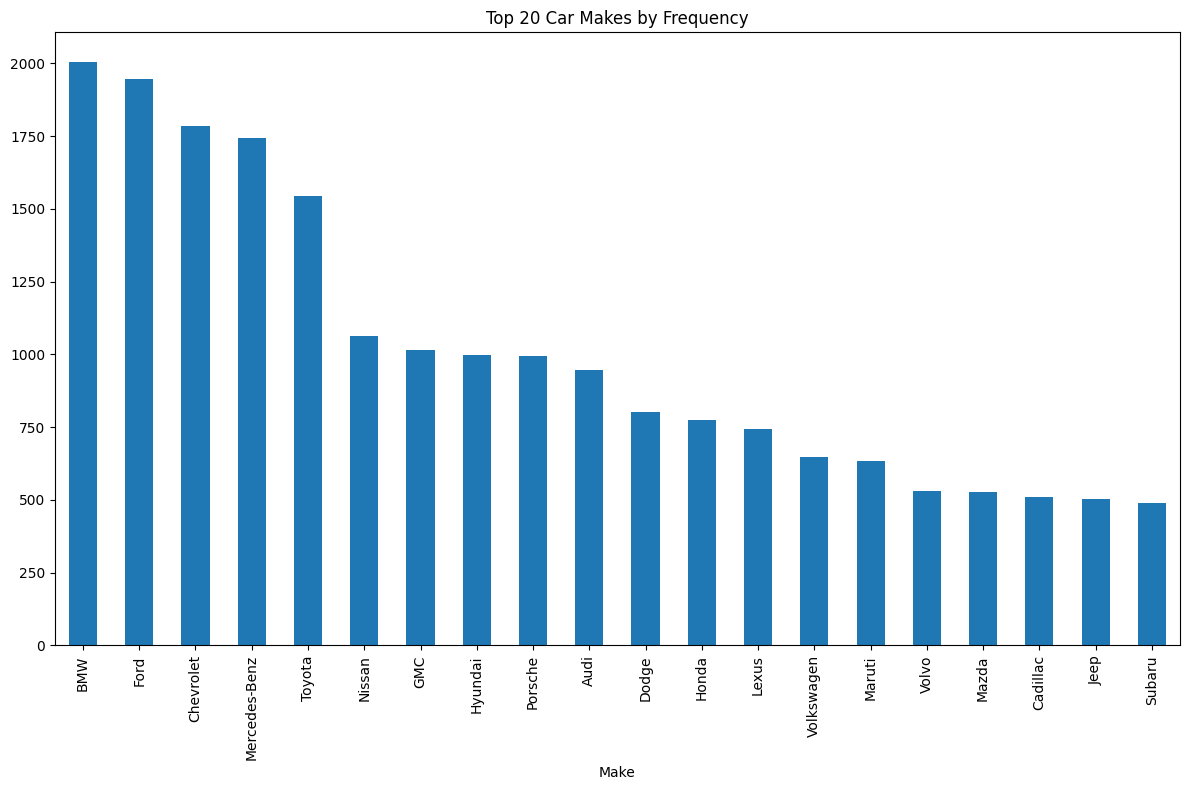

In [7]:
# Count frequency of each make to identify the most common ones
make_counts = combined_cars_df['Make'].value_counts()

# Plot distribution of makes
plt.figure(figsize=(12, 8))
make_counts.head(20).plot(kind='bar')
plt.title('Top 20 Car Makes by Frequency')
plt.tight_layout()

# Select top N makes to keep number of classes manageable
N = 159  # Your target number of classes
top_makes = make_counts.head(N).index.tolist()
print(f"Using top {len(top_makes)} makes as classes")

In [8]:
# Preparation of the images & datasets


def process_image(args):
    i, img_file, source_dir, output_dir, top_makes, train_end, valid_end = args
    try:
        # Determine split
        if i < train_end:
            split = 'train'
        elif i < valid_end:
            split = 'valid'
        else:
            split = 'test'

        # Source path
        src_path = os.path.join(source_dir, img_file)
        
        # Determine class label based on filename
        img_file_lower = img_file.lower()
        img_class = 'other'  # Default class
        
        for make in top_makes:
            # Simple string matching
            if make.lower() in img_file_lower:
                img_class = make
                break
        
        # Replace spaces with underscores for directory names
        class_dir_name = img_class.replace(' ', '_')
        
        # Destination directory
        dst_dir = os.path.join(output_dir, split, class_dir_name)
        
        # Resize and save the image
        img = cv2.imread(src_path)
        if img is None:
            return f"Warning: Could not read image {src_path}"
            
        # Use INTER_AREA for downsampling
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        dst_path = os.path.join(dst_dir, img_file)
        cv2.imwrite(dst_path, img_resized)
        
        return None  # No error
        
    except Exception as e:
        return f"Error processing {img_file}: {str(e)}"


def prepare_dataset_sequential(source_dir, output_dir='./data', top_makes=None, 
                           sample_size=20000, train_split=0.7, valid_split=0.15):
    """
    Prepare a dataset with class labels based on top car makes (sequential version).
    """

    # Create output directories
    for split_dir in [os.path.join(output_dir, split) for split in ['train', 'valid', 'test']]:
        if os.path.exists(split_dir):
            shutil.rmtree(split_dir)
        os.makedirs(split_dir, exist_ok=True)
    
    # Get all images
    image_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    # Limit to sample size
    image_files = image_files[:sample_size]
    print(f"Using {len(image_files)} images (from total {len(os.listdir(source_dir))})")

    # Calculate split indices
    train_end = int(len(image_files) * train_split)
    valid_end = train_end + int(len(image_files) * valid_split)
    
    # Track which classes have been found in images
    found_classes = set()
    
    # First pass: identify which classes are actually present in the dataset
    print("Scanning images to identify classes...")
    for img_file in tqdm(image_files, desc="Identifying classes"):
        img_file_lower = img_file.lower()
        for make in top_makes:
            if make.lower() in img_file_lower:
                found_classes.add(make)
                break
    
    # Add 'other' class if needed
    found_classes.add('other')  # Always include 'other' class
    
    print(f"Found {len(found_classes)} classes in the dataset")
    
    # Create only directories for classes that exist
    for split in ['train', 'valid', 'test']:
        for make in found_classes:
            safe_make = make.replace(' ', '_')
            os.makedirs(os.path.join(output_dir, split, safe_make), exist_ok=True)
    
    # Process images sequentially with tqdm progress bar
    errors = []
    class_distribution = {make: 0 for make in found_classes}
    
    for i, img_file in tqdm(enumerate(image_files), total=len(image_files), desc="Processing images"):
        try:
            # Determine split
            if i < train_end:
                split = 'train'
            elif i < valid_end:
                split = 'valid'
            else:
                split = 'test'

            # Source path
            src_path = os.path.join(source_dir, img_file)
            
            # Determine class label based on filename
            img_file_lower = img_file.lower()
            img_class = 'other'  # Default class
            
            for make in found_classes:
                if make != 'other' and make.lower() in img_file_lower:
                    img_class = make
                    break
            
            # Replace spaces with underscores for directory names
            class_dir_name = img_class.replace(' ', '_')
            
            # Destination directory
            dst_dir = os.path.join(output_dir, split, class_dir_name)
            
            # Resize and save the image
            img = cv2.imread(src_path)
            if img is None:
                errors.append(f"Warning: Could not read image {src_path}")
                continue
                
            img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
            dst_path = os.path.join(dst_dir, img_file)
            cv2.imwrite(dst_path, img_resized)
            
            # Update class distribution counter
            class_distribution[img_class] += 1
            
        except Exception as e:
            errors.append(f"Error processing {img_file}: {str(e)}")
    
    # Print errors if any
    if errors:
        print("\nErrors encountered:")
        for error in errors:
            print(error)
    
    # Print class distribution
    print("\nClass distribution:")
    for make, count in sorted(class_distribution.items(), key=lambda x: x[1], reverse=True):
        print(f"{make}: {count} images")
    
    # Check for empty classes again (shouldn't happen with our new approach)
    empty_classes = [make for make, count in class_distribution.items() if count == 0]
    if empty_classes:
        print(f"\nWarning: {len(empty_classes)} empty classes detected.")
        print(f"Empty classes: {empty_classes}")
        
        # Remove empty class directories to prevent errors
        for split in ['train', 'valid', 'test']:
            for empty_class in empty_classes:
                empty_dir = os.path.join(output_dir, split, empty_class.replace(' ', '_'))
                if os.path.exists(empty_dir):
                    shutil.rmtree(empty_dir)
                    print(f"Removed empty directory: {empty_dir}")

    print("\nDataset preparation complete.")
    
    # Return only class names that have images
    return [make.replace(' ', '_') for make in found_classes if class_distribution[make] > 0]


def filter_out_other_class(base_dir):
    """
    Remove the 'other' class folder from all dataset splits
    """
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(base_dir, split, 'other')
        if os.path.exists(other_dir):
            print(f"Removing 'other' class from {split} split")
            shutil.rmtree(other_dir)
            print(f"Removed: {other_dir}")
        else:
            print(f"No 'other' class found in {split} split")
    
    print("Removed 'other' class from all dataset splits")
    
    
# Modified dataset loading code with error handling
def create_image_datasets(base_dir, data_transforms):
    """Create image datasets with error handling for empty class directories"""
    datasets_dict = {}
    
    for split in ['train', 'valid', 'test']:
        split_dir = os.path.join(base_dir, split)
        
        # Get list of non-empty class directories
        valid_classes = []
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if os.path.isdir(class_dir):
                # Check if directory has at least one valid image
                valid_files = [f for f in os.listdir(class_dir) 
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if valid_files:
                    valid_classes.append(class_name)
                else:
                    # Remove empty directory to avoid future errors
                    print(f"Removing empty class directory: {class_dir}")
                    shutil.rmtree(class_dir)
        
        print(f"Found {len(valid_classes)} valid classes in {split} split")
        
        # Create dataset with only valid classes
        try:
            datasets_dict[split] = datasets.ImageFolder(split_dir, transform=data_transforms[split])
        except Exception as e:
            print(f"Error loading {split} dataset: {str(e)}")
            # Create empty dataset as fallback
            datasets_dict[split] = None
    
    return datasets_dict


In [9]:
# Unfreezing layers

# Progressive unfreezing function
# non torchvision model
# def unfreeze_layers(model, num_layers):
#     """Unfreeze the last n layers of the model"""
#     trainable_layers = []
#     for name, param in model.named_parameters():
#         if 'classifier' in name:
#             param.requires_grad = True
#             trainable_layers.append(name)
#         elif 'bn' in name or 'batchnorm' in name or 'norm' in name:
#             param.requires_grad = True
#             trainable_layers.append(name)
    
#     # Count parameters in model.resnet (excluding classifier)
#     resnet_layers = []
#     for name, param in model.resnet.named_parameters():
#         resnet_layers.append(name)
    
#     # Reverse so we unfreeze from the end first
#     resnet_layers.reverse()
    
#     # Unfreeze the specified number of layers
#     unfrozen = 0
#     for name in resnet_layers:
#         if unfrozen >= num_layers:
#             break
#         param = model.resnet.get_parameter(name)
#         param.requires_grad = True
#         trainable_layers.append('resnet.' + name)
#         unfrozen += 1
        
#     print(f"Unfrozen {len(trainable_layers)} layers in total")
#     return trainable_layers


def unfreeze_layers(model, num_blocks):
    """Unfreeze blocks of ResNet model starting from the end"""
    # First freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    trainable_layers = []
    
    # Always unfreeze fully connected layer (classifier)
    for name, param in model.fc.named_parameters():
        param.requires_grad = True
        trainable_layers.append(f"fc.{name}")
    
    # Define blocks to unfreeze in order (from last to first)
    if num_blocks > 0:
        blocks_to_unfreeze = []
        
        # Add layer4 (last block)
        if num_blocks >= 1:
            blocks_to_unfreeze.append('layer4')
        
        # Add layer3
        if num_blocks >= 2:
            blocks_to_unfreeze.append('layer3')
        
        # Add layer2
        if num_blocks >= 3:
            blocks_to_unfreeze.append('layer2')
        
        # Add layer1
        if num_blocks >= 4:
            blocks_to_unfreeze.append('layer1')
        
        # Unfreeze the selected blocks
        for block_name in blocks_to_unfreeze:
            block = getattr(model, block_name)
            for name, param in block.named_parameters():
                param.requires_grad = True
                trainable_layers.append(f"{block_name}.{name}")
    
    print(f"Unfrozen {len(trainable_layers)} layers in total")
    return trainable_layers

In [10]:
# GPU & Memory-related functions


def check_gpu_utilization():
    """Monitor GPU usage the best we can with DirectML"""
    try:
        print("\nGPU Metrics:")
        # Get process memory info as a proxy
        process = psutil.Process(os.getpid())
        print(f"Process memory usage: {process.memory_info().rss / 1024**2:.2f} MB")
        print("Note: DirectML doesn't expose detailed GPU metrics")
    except Exception as e:
        print(f"Error getting metrics: {str(e)}")
       
        
def aggressive_memory_cleanup():
    """Aggressively clean up memory"""
    import gc
    
    # Force garbage collection
    gc.collect()
    
    # Clear DirectML cache if possible
    if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
        torch.directml.empty_cache()
        print("Cleared DirectML cache")


def memory_efficient_forward(model, inputs, max_retries=3):
    """Better OOM handling for forward pass"""
    batch_size = inputs.shape[0]
    
    # First try: normal forward pass with full batch
    try:
        return model(inputs)
    except RuntimeError as e:
        # If OOM, try to split the batch
        if "out of memory" in str(e) or "not enough GPU" in str(e):
            print(f"OOM with batch size {batch_size}, trying to split batch...")
            
            # Clear cache immediately
            if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                torch.directml.empty_cache()
            
            # If batch size is already 1, we can't reduce further
            if batch_size <= 1:
                print("Cannot split batch further, minimum batch size reached")
                raise e
                
            # Try with half the batch size
            half = batch_size // 2
            try:
                # Process first half
                out1 = model(inputs[:half])
                # Process second half
                out2 = model(inputs[half:])
                
                # Combine results (assuming the model output has logits)
                if hasattr(out1, 'logits'):
                    combined_logits = torch.cat([out1.logits, out2.logits], dim=0)
                    # Create a new output object with combined logits
                    from transformers.modeling_outputs import ImageClassifierOutput
                    return ImageClassifierOutput(logits=combined_logits)
                else:
                    # For plain tensors
                    return torch.cat([out1, out2], dim=0)
            except RuntimeError:
                print("Still OOM after splitting batch. Please reduce batch size further.")
                raise
        else:
            # Not an OOM error
            raise e



In [16]:
# Training functions for the ResNet Model


# Configure DirectML
dml_device = dml.device(dml.default_device())
print(f"Using DirectML device: {dml.device_name(dml.default_device())}")

# Define paths
source_dir = './images/cars'  # Source directory containing all images
data_dir = './data'  # Output directory for train, valid, and test splits
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Initialize "variable" connection with the GPU
device = dml_device

torch.backends.cudnn.benchmark = True  # Speed up training

# Use the function
class_names = prepare_dataset_sequential(
    source_dir='./images/cars',
    output_dir='./data',
    top_makes=top_makes,
    sample_size=20000 # Adjust based on your available images
)

Using DirectML device: AMD  Radeon RX 7800 XT 
Using 20000 images (from total 114681)
Scanning images to identify classes...


Identifying classes: 100%|██████████| 20000/20000 [00:00<00:00, 273976.35it/s]


Found 47 classes in the dataset


Processing images: 100%|██████████| 20000/20000 [03:41<00:00, 90.42it/s] 


Class distribution:
other: 8792 images
Chevrolet: 903 images
Toyota: 822 images
Ford: 772 images
BMW: 732 images
Nissan: 690 images
Mercedes-Benz: 549 images
Audi: 543 images
Honda: 449 images
Hyundai: 355 images
GMC: 354 images
Kia: 347 images
Lexus: 337 images
Volkswagen: 286 images
Subaru: 274 images
Lincoln: 258 images
Mazda: 244 images
Porsche: 219 images
Dodge: 219 images
Volvo: 218 images
Cadillac: 217 images
Jeep: 213 images
MINI: 182 images
Acura: 175 images
Buick: 168 images
Jaguar: 166 images
Land Rover: 164 images
Infiniti: 158 images
Fiat: 149 images
Bentley: 135 images
Ram: 128 images
Mitsubishi: 114 images
Chrysler: 95 images
Aston Martin: 90 images
MG: 89 images
Maserati: 82 images
smart: 76 images
Alfa Romeo: 48 images
Rolls-Royce: 47 images
Lamborghini: 40 images
Genesis: 31 images
Tesla: 29 images
McLaren: 22 images
Ferrari: 15 images
SRT: 2 images
VPG: 1 images
STI: 1 images

Dataset preparation complete.


In [12]:
# Training functions regarding the model



def pseudo_label_other_images(model, data_dir, class_names, device, transforms, confidence_threshold=0.5, max_samples=3000):
    """
    Generate pseudo-labels for images in the 'other' class with more aggressive parameters.
    
    Args:
        model: Trained model to use for predictions
        data_dir: Base data directory
        class_names: List of class names
        device: Device to run model on
        transforms: Image transformations to apply
        confidence_threshold: Threshold to consider a prediction valid (lower = more aggressive)
        max_samples: Maximum number of samples to process from 'other' class (higher = more aggressive)
    """
    print("\nGenerating pseudo-labels for 'other' class images...")
    model.eval()
    
    moved_images = {split: 0 for split in ['train', 'valid', 'test']}
    total_other_images = {split: 0 for split in ['train', 'valid', 'test']}
    
    # Find 'other' class index to avoid labeling as 'other'
    other_idx = -1
    for i, cls in enumerate(class_names):
        if cls == 'other':
            other_idx = i
            break
    
    for split in ['train', 'valid', 'test']:
        other_dir = os.path.join(data_dir, split, 'other')
        if not os.path.exists(other_dir):
            continue
            
        other_images = [f for f in os.listdir(other_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        total_other_images[split] = len(other_images)
        
        if not other_images:
            continue
        
        # Process more images than before - more aggressive sampling
        if split == 'train' and len(other_images) > max_samples:
            sample_size = min(max_samples, len(other_images))
            other_images = random.sample(other_images, sample_size)
            print(f"Processing {sample_size} sampled images from {split}/other (from total {total_other_images[split]})")
        else:
            print(f"Processing {len(other_images)} images from {split}/other")
        
        # Process each image
        for img_file in tqdm(other_images, desc=f"Pseudo-labeling {split}/other"):
            img_path = os.path.join(other_dir, img_file)
            
            # Load and preprocess the image
            try:
                image = Image.open(img_path).convert('RGB')
                img_tensor = transforms(image).unsqueeze(0).to(device)
                
                # Get model prediction
                with torch.no_grad():
                    outputs = model(img_tensor)
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs
                    probs = torch.nn.functional.softmax(logits, dim=1)[0]
                    
                    # Mask out 'other' class to prevent it from being the top prediction
                    if other_idx >= 0:
                        probs[other_idx] = 0.0
                    
                    conf_val, pred_idx = torch.max(probs, 0)
                    confidence = conf_val.item()
                    pred_class = class_names[pred_idx.item()]
                
                # More aggressive threshold and explicit exclusion of 'other' class
                if confidence >= confidence_threshold and pred_class != 'other':
                    target_dir = os.path.join(data_dir, split, pred_class)
                    os.makedirs(target_dir, exist_ok=True)
                    target_path = os.path.join(target_dir, img_file)
                    
                    # Move the file
                    shutil.move(img_path, target_path)
                    moved_images[split] += 1
            
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    # Print summary
    print("\nPseudo-labeling summary:")
    for split in ['train', 'valid', 'test']:
        if total_other_images[split] > 0:
            percent = (moved_images[split] / total_other_images[split]) * 100
            print(f"{split}: Moved {moved_images[split]} of {total_other_images[split]} images ({percent:.1f}%)")
    
    return moved_images



def train_with_progressive_unfreezing(num_epochs=150, accumulation_steps=2):
    """
    Train the model with progressive unfreezing, focused only on known car classes.
    """
    global dataloaders, model, criterion, optimizer, scheduler, class_names, class_weights_tensor, learning_rate, batch_size
    
    # Create checkpoint directory
    checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Check for previous checkpoint to resume from
    interrupt_checkpoint_path = os.path.join(checkpoint_dir, 'interrupt_checkpoint.pth')
    start_epoch = 0
    start_time = time.time()
    best_acc = 0.0
    current_stage = 0
    
    
    if os.path.exists(interrupt_checkpoint_path):
        print(f"\nFound training checkpoint at {interrupt_checkpoint_path}, resuming...")
        try:
            checkpoint = torch.load(interrupt_checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            best_acc = checkpoint['best_acc']
            current_stage = checkpoint.get('stage', 0)
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            print(f"Resuming from epoch {start_epoch} with best accuracy: {best_acc:.4f} (stage {current_stage+1})")
        except Exception as e:
            print(f"Error loading training state: {e}")
            print("Starting from scratch instead")
    
    # Set up training stages with progressive unfreezing
    stages = [
        {'epochs': num_epochs // 3, 'unfreeze': 1},   
        {'epochs': num_epochs // 3, 'unfreeze': 2},  
        {'epochs': num_epochs // 3, 'unfreeze': 3}  
    ]
    
    # Calculate which stage and epoch within stage to start from
    stage_start_epoch = 0
    for i in range(current_stage):
        stage_start_epoch += stages[i]['epochs']
    
    stage_epoch = start_epoch - stage_start_epoch
    
    # Print initial GPU info
    check_gpu_utilization()
    
    try:
        # Loop through remaining stages
        for stage_idx in range(current_stage, len(stages)):
            stage = stages[stage_idx]
            print(f"\n--- Starting Stage {stage_idx+1}: Unfreezing {stage['unfreeze']} layers ---")
            
            # Unfreeze layers for this stage
            trainable_layers = unfreeze_layers(model, stage['unfreeze'])
            print(f"Training with {len(trainable_layers)} trainable layers")
            
            
            # SGD optimizer
            # Update optimizer with new trainable parameters
            stage_lr = learning_rate / (1.5 ** stage_idx)  # Lower LR as we unfreeze more
            # stage_lr = learning_rate / (3 ** stage_idx)  # More aggressive reduction between stages
            optimizer = optim.SGD(
                [p for p in model.parameters() if p.requires_grad],
                lr=stage_lr,
                momentum=0.9,
                #weight_decay=1e-5,
                weight_decay=1e-5,
                nesterov=True
            )
            
            # Adam optimizer
            # optimizer = torch.optim.Adam(
            #     [p for p in model.parameters() if p.requires_grad],
            #     lr=learning_rate,
            #     weight_decay=1e-5
            # )
            
            # Create OneCycleLR scheduler for this stage
            # scheduler = torch.optim.lr_scheduler.OneCycleLR(
            #     optimizer, 
            #     max_lr=stage_lr,
            #     epochs=stage['epochs'] - stage_epoch,  # Remaining epochs in this stage
            #     steps_per_epoch=len(dataloaders['train']),
            #     pct_start=0.3,  # Warm up for 30% of the cycle
            #     div_factor=25.0,  # max_lr/25 is initial learning rate
            #     final_div_factor=10000.0  # min_lr = max_lr/div_factor/final_div_factor
            # )

            # # More gradual warmup
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, 
                max_lr=stage_lr,
                epochs=stage['epochs'] - stage_epoch,
                steps_per_epoch=len(dataloaders['train']),
                pct_start=0.2,  # Increase warm-up period
                div_factor=10.0,  # Start with lower learning rate
                final_div_factor=1000.0
            )
            
            # Train for the epochs in this stage
            for epoch in range(stage_epoch, stage['epochs']):
                global_epoch = stage_start_epoch + epoch
                print(f"\nEpoch {global_epoch+1}/{num_epochs} (Stage {stage_idx+1}, Epoch {epoch+1}/{stage['epochs']})")
                print("-" * 20)
                epoch_start = time.time()
                
                # Save checkpoint every 10 global epochs
                if (global_epoch + 1) % 10 == 0:
                    checkpoint_path = os.path.join(checkpoint_dir, f'model_checkpoint_epoch_{global_epoch+1}.pth')
                    torch.save({
                        'epoch': global_epoch,
                        'stage': stage_idx,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                    }, checkpoint_path)
                    print(f"Saved checkpoint at epoch {global_epoch+1}")
                
                # Training and validation loop
                for phase in ['train', 'valid']:
                    # Skip validation if dataloader doesn't exist
                    if phase == 'valid' and dataloaders['valid'] is None:
                        print("Skipping validation - no valid dataloader found")
                        continue
                    
                    if phase == 'train':
                        model.train()
                        optimizer.zero_grad()
                    else:
                        model.eval()
                
                    running_loss = 0.0
                    running_corrects = 0
                    total = 0
                    batch_times = []
                
                    # Use tqdm for progress tracking
                    loop = tqdm(dataloaders[phase], desc=f"{phase}")
                    for batch_idx, (inputs, labels) in enumerate(loop):
                        batch_start = time.time()
                        
                        inputs, labels = inputs.to(device), labels.to(device)
                        
                        try:
                            with torch.set_grad_enabled(phase == 'train'):
                                # Use memory-efficient forward pass
                                outputs = memory_efficient_forward(model, inputs)
                                logits = outputs.logits if hasattr(outputs, 'logits') else outputs

                                
                                if phase == 'train':
                                    # Scale loss by accumulation steps for gradient accumulation
                                    loss = criterion(logits, labels) / accumulation_steps
                                    loss.backward()
                                    
                                    # Only update weights after accumulation_steps or at the end of epoch
                                    if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(dataloaders[phase]):
                                        # Gradient clipping to prevent loss explosion
                                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                        optimizer.step()
                                        
                                        # Step OneCycleLR scheduler after each batch during training
                                        scheduler.step()
                                        
                                        optimizer.zero_grad()
                                else:
                                    # For validation, use normal loss calculation
                                    loss = criterion(logits, labels)
                                    
                                _, preds = torch.max(logits, 1)
                            
                            # After successful forward/backward pass, update metrics
                            # For reporting, use the unscaled loss value
                            actual_loss = loss.item() * (accumulation_steps if phase == 'train' else 1)
                            running_loss += actual_loss * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            total += labels.size(0)
                            
                            # Calculate batch time
                            batch_time = time.time() - batch_start
                            batch_times.append(batch_time)
                            
                            # Update progress bar with more info
                            current_lr = optimizer.param_groups[0]['lr']
                            loop.set_postfix(loss=actual_loss, lr=f"{current_lr:.6f}", batch_time=f"{batch_time:.3f}s")
                            
                        except Exception as e:
                            print(f"Error in batch {batch_idx}: {e}")
                            if "out of memory" in str(e) or "not enough GPU" in str(e):
                                aggressive_memory_cleanup()
                            # Skip this batch but continue training
                            continue

                    epoch_loss = running_loss / total
                    epoch_acc = running_corrects.double() / total
                    avg_batch_time = sum(batch_times) / len(batch_times)
                
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                    print(f"Average batch processing time: {avg_batch_time:.3f} seconds")
                    print(f"Effective batch size: {batch_size * (accumulation_steps if phase == 'train' else 1)}")
                    
                    # Save model if we got better validation accuracy
                    if phase == 'valid' and epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_resnet_car_classifier.pth')
                        print(f"Saved new best model with accuracy: {best_acc:.4f}")
                
                epoch_time = time.time() - epoch_start
                print(f"Epoch complete in {epoch_time:.2f}s")
                
                # Check GPU status after epoch
                print(f"GPU status after epoch {global_epoch+1}:")
                check_gpu_utilization()
                aggressive_memory_cleanup()
                
                # Clear DirectML cache if supported
                if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
                    torch.directml.empty_cache()
                    print("Cleared DirectML cache")
            
            # Update for next stage
            stage_start_epoch += stage['epochs']
            stage_epoch = 0  # Reset epoch counter for next stage
            
            print(f"Completed stage {stage_idx+1}")
            
    except KeyboardInterrupt:
        print("\n" + "="*60)
        print("TRAINING INTERRUPTED BY USER! Saving checkpoint...")
        print("="*60)
        
        # Save the model and training state when interrupted
        torch.save({
            'epoch': global_epoch,
            'stage': stage_idx,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
        }, interrupt_checkpoint_path)
        print(f"Checkpoint saved to {interrupt_checkpoint_path}")
        print(f"To resume training, simply run the notebook again.")
        print("="*60)
    
    # Code that executes whether training completed or was interrupted
    total_time = time.time() - start_time
    print(f"\nTraining completed or interrupted after {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")
        
    # Save final model if training completed normally
    if 'global_epoch' in locals() and global_epoch is not None and global_epoch == num_epochs - 1:
        try:
            torch.save(model.state_dict(), 'final_resnet_car_classifier.pth')
            print("Final model saved as final_resnet_car_classifier.pth")
        except Exception as e:
            print(f"Error saving final model: {e}")
            # Try saving with CPU
            try:
                torch.save(model.cpu().state_dict(), 'final_resnet_car_classifier.pth')
                model = model.to(device)  # Move back to original device
                print("Final model saved to CPU as final_resnet_car_classifier.pth")
            except Exception as e2:
                print(f"Could not save final model: {e2}")
    
    return best_acc



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            total = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
                
            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Update scheduler in training phase
            if phase == 'train':
                scheduler.step()
            
            # Save best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f'New best accuracy: {best_acc:.4f}')
        
        print()
    
    return model




In [13]:
# Force garbage collection
import gc
gc.collect()

# Try to clear DirectML cache
if hasattr(torch, 'directml') and hasattr(torch.directml, 'empty_cache'):
    torch.directml.empty_cache()
    print("Cleared DirectML cache")

# Print available memory
print(f"Available system memory: {psutil.virtual_memory().available / 1024**2:.2f} MB")

Available system memory: 11698.76 MB


In [17]:
# Processing the transforms & dataloaders

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Optimized size for modern GPUs
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Added saturation for better diversity
        transforms.RandomRotation(10),  # Increased rotation range
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),  # Added translation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),  # Deterministic sizing for validation
        transforms.CenterCrop(224),  # Consistent crop area
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # Same as validation for consistency
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


# First run the filtering function
filter_out_other_class(data_dir)


# Use the function to create datasets
image_datasets = create_image_datasets(data_dir, data_transforms)


# Hyperparameters
batch_size = 8
num_epochs = 50
learning_rate = 0.01

# Image processing
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-101")
class ProcessorImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.classes = dataset.classes  # Preserve class info from original dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        # Check if image is already a tensor
        if isinstance(image, torch.Tensor):
            # Convert tensor back to PIL image
            image = transforms.ToPILImage()(image)
        
        # Now we have a PIL image, we can proceed
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # Process with Hugging Face processor
        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze(0)
        
        return pixel_values, label

# Ensure all datasets were created successfully with the image processor
if all(dataset is not None for dataset in image_datasets.values()):
    # Continue with your regular dataloader creation
    # train_dataset = ProcessorImageDataset(image_datasets['train'], image_processor)
    # valid_dataset = ProcessorImageDataset(image_datasets['valid'], image_processor) if image_datasets['valid'] is not None else None
    # test_dataset = ProcessorImageDataset(image_datasets['test'], image_processor) if image_datasets['test'] is not None else None
        
    # Calculate class weights
    class_counts = Counter([label for _, label in image_datasets['train']])
    total_samples = sum(class_counts.values())
    
    # Get actual classes from the dataset
    actual_class_names = image_datasets['train'].classes
    num_classes = len(actual_class_names)
    
    # Convert class weights to a tensor
    #class_weights = {cls: total_samples / class_counts.get(cls, 1) for cls in range(num_classes)}
    class_weights = {cls: math.sqrt(total_samples / class_counts.get(cls, 1)) for cls in range(num_classes)}
    
    # Handle missing classes in train_dataset
    class_weights_tensor = torch.zeros(num_classes, dtype=torch.float).to(dml_device)
    for cls, weight in class_weights.items():
        if cls < len(class_weights_tensor):
            class_weights_tensor[cls] = weight
    
    print(f"Number of actual classes in dataset: {num_classes}")
    
    # Assign weights to each sample
    sample_weights = [class_weights[label] for _, label in image_datasets['train']]
    
    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # Create dataloaders
    print(f"Recreating dataloaders with batch size = {batch_size}")
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4),
        'valid': DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['valid'] is not None else None,
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=4) if image_datasets['test'] is not None else None,
    }
    
    class_names = actual_class_names
else:
    print("Could not create all required datasets. Please check the data directories.")
    
    
print(f"Training with learning rate: {learning_rate}")
print(f"Shape of class_weights_tensor: {class_weights_tensor.shape}")
print(f"Expected number of classes: {num_classes}")
print("\nTesting if dataloader works...")
try:
    test_batch = next(iter(dataloaders['train']))
    print(f"Successfully loaded a batch with shape: {test_batch[0].shape}")
    print(f"Labels shape: {test_batch[1].shape}")
    print(f"First few labels: {test_batch[1][:5]}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")

Removing 'other' class from train split
Removed: ./data\train\other
Removing 'other' class from valid split
Removed: ./data\valid\other
Removing 'other' class from test split
Removed: ./data\test\other
Removed 'other' class from all dataset splits
Removing empty class directory: ./data\train\VPG
Found 45 valid classes in train split
Removing empty class directory: ./data\valid\Ferrari
Removing empty class directory: ./data\valid\SRT
Removing empty class directory: ./data\valid\STI
Found 43 valid classes in valid split
Removing empty class directory: ./data\test\SRT
Removing empty class directory: ./data\test\STI
Removing empty class directory: ./data\test\VPG
Found 43 valid classes in test split
Number of actual classes in dataset: 45
Recreating dataloaders with batch size = 8
Training with learning rate: 0.01
Shape of class_weights_tensor: torch.Size([45])
Expected number of classes: 45

Testing if dataloader works...
Successfully loaded a batch with shape: torch.Size([8, 3, 224, 224]

In [18]:
# Preparing the model, criterion, optimization,... 

# DEPENDS ON UR GPU & CPU, PROCEED WITH CARE
#model = models.resnet101(weights='IMAGENET1K_V2')
model = models.resnext101_32x8d(weights='IMAGENET1K_V2')  # Even more complex

# Use this if the ones above fail
#model = models.resnet50(weights='IMAGENET1K_V2')


# Initialize ResNet model from Hugging Face with DirectML compatibility
# model = ResNetForImageClassification.from_pretrained(
#     "microsoft/resnet-50",  # Pre-trained
#     num_labels=num_classes,  # Use your number of car classes
#     ignore_mismatched_sizes=True,  # Handle different size of final classification layer
# )

# Check if there's a previous checkpoint to load
checkpoint_path = './checkpoints/interrupt_checkpoint.pth'
if os.path.exists(checkpoint_path):
    print(f"Found previous checkpoint at {checkpoint_path}, loading...")
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Successfully loaded model weights from checkpoint")
    except Exception as e:
        print(f"Error loading model from checkpoint: {e}")
        print("Starting with fresh model")


# Unfreeze more layers to increase computation
# for param in list(model.parameters())[:-30*2]:  # Unfreeze 16 layers, change this depending on the computation
#     param.requires_grad = False


# Start with all layers frozen except the last few
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze only classifier at first
# for param in model.classifier.parameters():
#     param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

    
# UNCOMMENT THESE IF YOU ARE USING A TORCH MODEL
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Making sure the model uses DirectML regarding AMD GPUs
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


# SGD optimizer
# optimizer = optim.SGD( 
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     momentum=0.9, 
#     weight_decay=1e-4,
#     #weight_decay=5e-4,
#     nesterov=True
# )

# Adam optimizer
# optimizer = torch.optim.Adam(
#     [p for p in model.parameters() if p.requires_grad],
#     lr=learning_rate,
#     weight_decay=1e-5
# )

In [50]:
# Training the model

# Generate pseudo-labeling epochs at intervals of 5
# pseudo_label_epochs = list(range(25, num_epochs+1, 25))

print("\nStarting progressive unfreezing training (without 'other' class)...")
#print(f"Will perform pseudo-labeling at epochs: {pseudo_label_epochs}")
train_with_progressive_unfreezing(num_epochs=num_epochs, accumulation_steps=2)  # was 2 before, testing phase



# Without the complex progressive unfreezing
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# train_model(model=model,
#             criterion=criterion,
#             optimizer=optimizer,
#             scheduler=scheduler,
#             num_epochs=50)


Starting progressive unfreezing training (without 'other' class)...

GPU Metrics:
Process memory usage: 1719.46 MB
Note: DirectML doesn't expose detailed GPU metrics

--- Starting Stage 1: Unfreezing 1 layers ---
Unfrozen 32 layers in total
Training with 32 trainable layers

Epoch 1/50 (Stage 1, Epoch 1/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.32it/s, batch_time=0.142s, loss=1.67, lr=0.001532] 


train Loss: 3.2611 Acc: 0.1292
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.86it/s, batch_time=0.022s, loss=5.49, lr=0.001532] 


valid Loss: 4.4462 Acc: 0.1537
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.1537
Epoch complete in 135.90s
GPU status after epoch 1:

GPU Metrics:
Process memory usage: 1420.34 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 2/50 (Stage 1, Epoch 2/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.30it/s, batch_time=0.162s, loss=2.73, lr=0.003001] 


train Loss: 2.6298 Acc: 0.2505
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.79it/s, batch_time=0.022s, loss=5.69, lr=0.003001] 


valid Loss: 5.0545 Acc: 0.2139
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.2139
Epoch complete in 136.33s
GPU status after epoch 2:

GPU Metrics:
Process memory usage: 1446.69 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 3/50 (Stage 1, Epoch 3/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.31it/s, batch_time=0.141s, loss=2.5, lr=0.005061]  


train Loss: 2.5102 Acc: 0.2843
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.72it/s, batch_time=0.022s, loss=11.9, lr=0.005061] 


valid Loss: 7.1914 Acc: 0.2057
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 133.88s
GPU status after epoch 3:

GPU Metrics:
Process memory usage: 1441.02 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 4/50 (Stage 1, Epoch 4/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.32it/s, batch_time=0.142s, loss=4.01, lr=0.007225] 


train Loss: 2.3585 Acc: 0.3134
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.87it/s, batch_time=0.023s, loss=10.8, lr=0.007225]  


valid Loss: 7.3061 Acc: 0.2370
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.2370
Epoch complete in 135.83s
GPU status after epoch 4:

GPU Metrics:
Process memory usage: 1527.59 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 5/50 (Stage 1, Epoch 5/16)
--------------------


train: 100%|██████████| 984/984 [01:57<00:00,  8.37it/s, batch_time=0.142s, loss=2.47, lr=0.008981] 


train Loss: 2.2887 Acc: 0.3304
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.72it/s, batch_time=0.022s, loss=13.8, lr=0.008981] 


valid Loss: 7.3353 Acc: 0.2287
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 132.96s
GPU status after epoch 5:

GPU Metrics:
Process memory usage: 1523.82 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 6/50 (Stage 1, Epoch 6/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.33it/s, batch_time=0.143s, loss=1.21, lr=0.009914] 


train Loss: 2.1508 Acc: 0.3579
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.90it/s, batch_time=0.022s, loss=14.3, lr=0.009914] 


valid Loss: 7.1872 Acc: 0.3050
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.3050
Epoch complete in 135.62s
GPU status after epoch 6:

GPU Metrics:
Process memory usage: 1569.61 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 7/50 (Stage 1, Epoch 7/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.31it/s, batch_time=0.141s, loss=2.65, lr=0.009986] 


train Loss: 2.0608 Acc: 0.3835
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.70it/s, batch_time=0.022s, loss=20.3, lr=0.009986] 


valid Loss: 5.5093 Acc: 0.3050
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 133.87s
GPU status after epoch 7:

GPU Metrics:
Process memory usage: 1456.87 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 8/50 (Stage 1, Epoch 8/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.33it/s, batch_time=0.143s, loss=0.902, lr=0.009904]


train Loss: 1.9447 Acc: 0.4049
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.93it/s, batch_time=0.023s, loss=8.93, lr=0.009904] 


valid Loss: 6.6080 Acc: 0.2961
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 133.42s
GPU status after epoch 8:

GPU Metrics:
Process memory usage: 1481.38 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 9/50 (Stage 1, Epoch 9/16)
--------------------


train: 100%|██████████| 984/984 [01:56<00:00,  8.42it/s, batch_time=0.141s, loss=1.95, lr=0.009747] 


train Loss: 1.8568 Acc: 0.4310
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 14.07it/s, batch_time=0.023s, loss=19.6, lr=0.009747]   


valid Loss: 7.6903 Acc: 0.3316
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.3316
Epoch complete in 134.35s
GPU status after epoch 9:

GPU Metrics:
Process memory usage: 1529.71 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 10/50 (Stage 1, Epoch 10/16)
--------------------
Saved checkpoint at epoch 10


train: 100%|██████████| 984/984 [01:57<00:00,  8.37it/s, batch_time=0.141s, loss=1.01, lr=0.009519] 


train Loss: 1.7450 Acc: 0.4578
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 14.02it/s, batch_time=0.022s, loss=9.6, lr=0.009519]    


valid Loss: 6.4691 Acc: 0.3304
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 136.58s
GPU status after epoch 10:

GPU Metrics:
Process memory usage: 1569.79 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 11/50 (Stage 1, Epoch 11/16)
--------------------


train: 100%|██████████| 984/984 [01:58<00:00,  8.31it/s, batch_time=0.142s, loss=2.53, lr=0.009224] 


train Loss: 1.7440 Acc: 0.4515
Average batch processing time: 0.111 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.97it/s, batch_time=0.023s, loss=15.6, lr=0.009224] 


valid Loss: 7.6234 Acc: 0.3712
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.3712
Epoch complete in 136.06s
GPU status after epoch 11:

GPU Metrics:
Process memory usage: 1614.75 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 12/50 (Stage 1, Epoch 12/16)
--------------------


train: 100%|██████████| 984/984 [01:57<00:00,  8.39it/s, batch_time=0.141s, loss=1.38, lr=0.008864] 


train Loss: 1.6285 Acc: 0.4896
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.91it/s, batch_time=0.022s, loss=16.6, lr=0.008864] 


valid Loss: 6.2947 Acc: 0.3676
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 132.55s
GPU status after epoch 12:

GPU Metrics:
Process memory usage: 1587.77 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 13/50 (Stage 1, Epoch 13/16)
--------------------


train: 100%|██████████| 984/984 [01:56<00:00,  8.41it/s, batch_time=0.141s, loss=0.661, lr=0.008447]


train Loss: 1.5712 Acc: 0.4926
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.96it/s, batch_time=0.022s, loss=13.8, lr=0.008447]  


valid Loss: 5.4422 Acc: 0.3670
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 132.16s
GPU status after epoch 13:

GPU Metrics:
Process memory usage: 1611.68 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 14/50 (Stage 1, Epoch 14/16)
--------------------


train: 100%|██████████| 984/984 [01:57<00:00,  8.41it/s, batch_time=0.141s, loss=1.8, lr=0.007978]  


train Loss: 1.5152 Acc: 0.5122
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.89it/s, batch_time=0.023s, loss=17.5, lr=0.007978] 


valid Loss: 6.5546 Acc: 0.3895
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.3895
Epoch complete in 134.80s
GPU status after epoch 14:

GPU Metrics:
Process memory usage: 1627.40 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 15/50 (Stage 1, Epoch 15/16)
--------------------


train: 100%|██████████| 984/984 [01:56<00:00,  8.41it/s, batch_time=0.141s, loss=1.51, lr=0.007464] 


train Loss: 1.4750 Acc: 0.5337
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.86it/s, batch_time=0.024s, loss=15.9, lr=0.007464]  


valid Loss: 8.2445 Acc: 0.3824
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 132.29s
GPU status after epoch 15:

GPU Metrics:
Process memory usage: 1632.04 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 16/50 (Stage 1, Epoch 16/16)
--------------------


train: 100%|██████████| 984/984 [01:57<00:00,  8.41it/s, batch_time=0.143s, loss=0.708, lr=0.006913]


train Loss: 1.3559 Acc: 0.5555
Average batch processing time: 0.110 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.81it/s, batch_time=0.023s, loss=16.9, lr=0.006913] 


valid Loss: 7.5770 Acc: 0.4048
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.4048
Epoch complete in 134.89s
GPU status after epoch 16:

GPU Metrics:
Process memory usage: 1625.27 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 1

--- Starting Stage 2: Unfreezing 2 layers ---
Unfrozen 242 layers in total
Training with 242 trainable layers

Epoch 17/50 (Stage 2, Epoch 1/16)
--------------------


train: 100%|██████████| 984/984 [04:25<00:00,  3.71it/s, batch_time=0.383s, loss=1.24, lr=0.001021] 


train Loss: 1.9111 Acc: 0.4372
Average batch processing time: 0.260 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.86it/s, batch_time=0.022s, loss=15.6, lr=0.001021] 


valid Loss: 4.5057 Acc: 0.3428
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 280.52s
GPU status after epoch 17:

GPU Metrics:
Process memory usage: 1665.21 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 18/50 (Stage 2, Epoch 2/16)
--------------------


train: 100%|██████████| 984/984 [04:25<00:00,  3.71it/s, batch_time=0.383s, loss=3.25, lr=0.002001] 


train Loss: 2.0763 Acc: 0.3779
Average batch processing time: 0.260 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.86it/s, batch_time=0.022s, loss=13.1, lr=0.002001] 


valid Loss: 6.9855 Acc: 0.2961
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 280.37s
GPU status after epoch 18:

GPU Metrics:
Process memory usage: 1702.20 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 19/50 (Stage 2, Epoch 3/16)
--------------------


train: 100%|██████████| 984/984 [04:24<00:00,  3.71it/s, batch_time=0.385s, loss=2.91, lr=0.003374] 


train Loss: 2.2423 Acc: 0.3404
Average batch processing time: 0.260 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.86it/s, batch_time=0.022s, loss=17.2, lr=0.003374] 


valid Loss: 5.5316 Acc: 0.2547
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 280.23s
GPU status after epoch 19:

GPU Metrics:
Process memory usage: 1730.87 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 20/50 (Stage 2, Epoch 4/16)
--------------------
Saved checkpoint at epoch 20


train: 100%|██████████| 984/984 [04:25<00:00,  3.70it/s, batch_time=0.382s, loss=2.42, lr=0.004816] 


train Loss: 2.3338 Acc: 0.3242
Average batch processing time: 0.261 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.90it/s, batch_time=0.023s, loss=14.3, lr=0.004816] 


valid Loss: 5.0222 Acc: 0.2624
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 287.91s
GPU status after epoch 20:

GPU Metrics:
Process memory usage: 1876.89 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 21/50 (Stage 2, Epoch 5/16)
--------------------


train: 100%|██████████| 984/984 [04:32<00:00,  3.61it/s, batch_time=0.393s, loss=2.59, lr=0.005987] 


train Loss: 2.3402 Acc: 0.3277
Average batch processing time: 0.267 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.52it/s, batch_time=0.022s, loss=7.06, lr=0.005987] 


valid Loss: 4.3744 Acc: 0.2748
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 288.31s
GPU status after epoch 21:

GPU Metrics:
Process memory usage: 1905.33 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 22/50 (Stage 2, Epoch 6/16)
--------------------


train: 100%|██████████| 984/984 [04:32<00:00,  3.61it/s, batch_time=0.394s, loss=1.73, lr=0.006610] 


train Loss: 2.2390 Acc: 0.3430
Average batch processing time: 0.268 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.40it/s, batch_time=0.023s, loss=8.29, lr=0.006610]  


valid Loss: 5.2010 Acc: 0.2518
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 288.76s
GPU status after epoch 22:

GPU Metrics:
Process memory usage: 1918.00 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 23/50 (Stage 2, Epoch 7/16)
--------------------


train: 100%|██████████| 984/984 [04:31<00:00,  3.62it/s, batch_time=0.397s, loss=2.55, lr=0.006658] 


train Loss: 2.1779 Acc: 0.3543
Average batch processing time: 0.266 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.38it/s, batch_time=0.022s, loss=13.3, lr=0.006658] 


valid Loss: 4.9749 Acc: 0.3002
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 287.30s
GPU status after epoch 23:

GPU Metrics:
Process memory usage: 1927.66 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 24/50 (Stage 2, Epoch 8/16)
--------------------


train: 100%|██████████| 984/984 [04:34<00:00,  3.58it/s, batch_time=0.402s, loss=1.67, lr=0.006602] 


train Loss: 2.0679 Acc: 0.3805
Average batch processing time: 0.270 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.37it/s, batch_time=0.023s, loss=11.8, lr=0.006602] 


valid Loss: 4.6998 Acc: 0.3452
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 290.80s
GPU status after epoch 24:

GPU Metrics:
Process memory usage: 1845.21 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 25/50 (Stage 2, Epoch 9/16)
--------------------


train: 100%|██████████| 984/984 [04:32<00:00,  3.61it/s, batch_time=0.399s, loss=0.969, lr=0.006498]


train Loss: 1.9827 Acc: 0.3986
Average batch processing time: 0.268 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.32it/s, batch_time=0.022s, loss=17.4, lr=0.006498] 


valid Loss: 4.5254 Acc: 0.3564
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 288.73s
GPU status after epoch 25:

GPU Metrics:
Process memory usage: 1779.59 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 26/50 (Stage 2, Epoch 10/16)
--------------------


train: 100%|██████████| 984/984 [04:31<00:00,  3.63it/s, batch_time=0.394s, loss=0.593, lr=0.006346] 


train Loss: 1.8546 Acc: 0.4339
Average batch processing time: 0.266 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.42it/s, batch_time=0.022s, loss=21.8, lr=0.006346] 


valid Loss: 4.7639 Acc: 0.4125
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.4125
Epoch complete in 289.54s
GPU status after epoch 26:

GPU Metrics:
Process memory usage: 1788.50 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 27/50 (Stage 2, Epoch 11/16)
--------------------


train: 100%|██████████| 984/984 [04:30<00:00,  3.64it/s, batch_time=0.399s, loss=1.23, lr=0.006149] 


train Loss: 1.8375 Acc: 0.4397
Average batch processing time: 0.265 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.47it/s, batch_time=0.022s, loss=18.6, lr=0.006149] 


valid Loss: 5.5006 Acc: 0.3658
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 286.20s
GPU status after epoch 27:

GPU Metrics:
Process memory usage: 1580.62 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 28/50 (Stage 2, Epoch 12/16)
--------------------


train: 100%|██████████| 984/984 [04:30<00:00,  3.64it/s, batch_time=0.392s, loss=1.49, lr=0.005910] 


train Loss: 1.7977 Acc: 0.4501
Average batch processing time: 0.265 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.35it/s, batch_time=0.023s, loss=13.2, lr=0.005910] 


valid Loss: 4.5049 Acc: 0.3794
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 286.15s
GPU status after epoch 28:

GPU Metrics:
Process memory usage: 1625.73 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 29/50 (Stage 2, Epoch 13/16)
--------------------


train: 100%|██████████| 984/984 [04:30<00:00,  3.63it/s, batch_time=0.393s, loss=0.64, lr=0.005631] 


train Loss: 1.7117 Acc: 0.4647
Average batch processing time: 0.266 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.42it/s, batch_time=0.022s, loss=14.6, lr=0.005631] 


valid Loss: 4.8386 Acc: 0.3983
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 286.74s
GPU status after epoch 29:

GPU Metrics:
Process memory usage: 1671.07 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 30/50 (Stage 2, Epoch 14/16)
--------------------
Saved checkpoint at epoch 30


train: 100%|██████████| 984/984 [04:30<00:00,  3.64it/s, batch_time=0.393s, loss=1.25, lr=0.005318] 


train Loss: 1.6160 Acc: 0.4806
Average batch processing time: 0.265 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.46it/s, batch_time=0.023s, loss=16.2, lr=0.005318] 


valid Loss: 4.9560 Acc: 0.4173
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.4173
Epoch complete in 295.16s
GPU status after epoch 30:

GPU Metrics:
Process memory usage: 1738.57 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 31/50 (Stage 2, Epoch 15/16)
--------------------


train: 100%|██████████| 984/984 [04:32<00:00,  3.62it/s, batch_time=0.394s, loss=1.26, lr=0.004976] 


train Loss: 1.5696 Acc: 0.5008
Average batch processing time: 0.267 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.48it/s, batch_time=0.023s, loss=18.8, lr=0.004976] 


valid Loss: 4.6372 Acc: 0.4515
Average batch processing time: 0.037 seconds
Effective batch size: 8
Saved new best model with accuracy: 0.4515
Epoch complete in 290.36s
GPU status after epoch 31:

GPU Metrics:
Process memory usage: 1742.11 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 32/50 (Stage 2, Epoch 16/16)
--------------------


train: 100%|██████████| 984/984 [04:45<00:00,  3.45it/s, batch_time=0.408s, loss=0.697, lr=0.004608]


train Loss: 1.5191 Acc: 0.5169
Average batch processing time: 0.280 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:16<00:00, 12.48it/s, batch_time=0.023s, loss=17.8, lr=0.004608] 


valid Loss: 4.8605 Acc: 0.4267
Average batch processing time: 0.039 seconds
Effective batch size: 8
Epoch complete in 302.01s
GPU status after epoch 32:

GPU Metrics:
Process memory usage: 1742.25 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 2

--- Starting Stage 3: Unfreezing 3 layers ---
Unfrozen 281 layers in total
Training with 281 trainable layers

Epoch 33/50 (Stage 3, Epoch 1/16)
--------------------


train: 100%|██████████| 984/984 [05:28<00:00,  3.00it/s, batch_time=0.474s, loss=3.4, lr=0.000681]   


train Loss: 1.4424 Acc: 0.5419
Average batch processing time: 0.322 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:17<00:00, 11.87it/s, batch_time=0.024s, loss=19.7, lr=0.000681]  


valid Loss: 4.7410 Acc: 0.4439
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 346.08s
GPU status after epoch 33:

GPU Metrics:
Process memory usage: 1788.30 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 34/50 (Stage 3, Epoch 2/16)
--------------------


train: 100%|██████████| 984/984 [05:05<00:00,  3.22it/s, batch_time=0.431s, loss=1.69, lr=0.001334] 


train Loss: 1.4794 Acc: 0.5338
Average batch processing time: 0.299 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.38it/s, batch_time=0.023s, loss=23.5, lr=0.001334] 


valid Loss: 4.9733 Acc: 0.3966
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 321.03s
GPU status after epoch 34:

GPU Metrics:
Process memory usage: 1814.75 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 35/50 (Stage 3, Epoch 3/16)
--------------------


train: 100%|██████████| 984/984 [04:55<00:00,  3.33it/s, batch_time=0.435s, loss=1.17, lr=0.002249] 


train Loss: 1.6432 Acc: 0.4846
Average batch processing time: 0.291 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.84it/s, batch_time=0.022s, loss=12.8, lr=0.002249] 


valid Loss: 5.0481 Acc: 0.3404
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 310.90s
GPU status after epoch 35:

GPU Metrics:
Process memory usage: 1834.04 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 36/50 (Stage 3, Epoch 4/16)
--------------------


train: 100%|██████████| 984/984 [04:55<00:00,  3.33it/s, batch_time=0.427s, loss=1.66, lr=0.003211] 


train Loss: 1.8466 Acc: 0.4371
Average batch processing time: 0.291 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.85it/s, batch_time=0.023s, loss=13.5, lr=0.003211] 


valid Loss: 4.9566 Acc: 0.3067
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 310.90s
GPU status after epoch 36:

GPU Metrics:
Process memory usage: 1903.18 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 37/50 (Stage 3, Epoch 5/16)
--------------------


train: 100%|██████████| 984/984 [04:59<00:00,  3.29it/s, batch_time=0.430s, loss=0.745, lr=0.003991]


train Loss: 1.9088 Acc: 0.4207
Average batch processing time: 0.295 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.70it/s, batch_time=0.023s, loss=14.2, lr=0.003991] 


valid Loss: 4.8395 Acc: 0.3493
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 314.78s
GPU status after epoch 37:

GPU Metrics:
Process memory usage: 1974.46 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 38/50 (Stage 3, Epoch 6/16)
--------------------


train: 100%|██████████| 984/984 [05:04<00:00,  3.23it/s, batch_time=0.447s, loss=2.61, lr=0.004406] 


train Loss: 1.9386 Acc: 0.4165
Average batch processing time: 0.300 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.27it/s, batch_time=0.023s, loss=14.5, lr=0.004406] 


valid Loss: 4.9451 Acc: 0.3398
Average batch processing time: 0.039 seconds
Effective batch size: 8
Epoch complete in 320.31s
GPU status after epoch 38:

GPU Metrics:
Process memory usage: 1673.78 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 39/50 (Stage 3, Epoch 7/16)
--------------------


train: 100%|██████████| 984/984 [05:04<00:00,  3.23it/s, batch_time=0.441s, loss=0.567, lr=0.004438]


train Loss: 1.8247 Acc: 0.4385
Average batch processing time: 0.300 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.26it/s, batch_time=0.022s, loss=14, lr=0.004438]   


valid Loss: 4.9670 Acc: 0.3493
Average batch processing time: 0.039 seconds
Effective batch size: 8
Epoch complete in 320.83s
GPU status after epoch 39:

GPU Metrics:
Process memory usage: 1635.50 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 40/50 (Stage 3, Epoch 8/16)
--------------------
Saved checkpoint at epoch 40


train: 100%|██████████| 984/984 [05:06<00:00,  3.21it/s, batch_time=0.476s, loss=0.56, lr=0.004402] 


train Loss: 1.8281 Acc: 0.4375
Average batch processing time: 0.301 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.48it/s, batch_time=0.022s, loss=12.1, lr=0.004402] 


valid Loss: 4.7356 Acc: 0.3824
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 328.35s
GPU status after epoch 40:

GPU Metrics:
Process memory usage: 1832.95 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 41/50 (Stage 3, Epoch 9/16)
--------------------


train: 100%|██████████| 984/984 [04:59<00:00,  3.28it/s, batch_time=0.432s, loss=2.58, lr=0.004332] 


train Loss: 1.7468 Acc: 0.4674
Average batch processing time: 0.295 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.72it/s, batch_time=0.023s, loss=10.9, lr=0.004332] 


valid Loss: 4.9114 Acc: 0.3611
Average batch processing time: 0.037 seconds
Effective batch size: 8
Epoch complete in 315.37s
GPU status after epoch 41:

GPU Metrics:
Process memory usage: 1856.74 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 42/50 (Stage 3, Epoch 10/16)
--------------------


train: 100%|██████████| 984/984 [05:01<00:00,  3.27it/s, batch_time=0.439s, loss=1.97, lr=0.004231] 


train Loss: 1.6806 Acc: 0.4754
Average batch processing time: 0.297 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:16<00:00, 13.21it/s, batch_time=0.023s, loss=10.7, lr=0.004231] 


valid Loss: 5.0576 Acc: 0.3966
Average batch processing time: 0.039 seconds
Effective batch size: 8
Epoch complete in 317.29s
GPU status after epoch 42:

GPU Metrics:
Process memory usage: 1850.45 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 43/50 (Stage 3, Epoch 11/16)
--------------------


train: 100%|██████████| 984/984 [05:00<00:00,  3.28it/s, batch_time=0.434s, loss=1.9, lr=0.004099]  


train Loss: 1.6031 Acc: 0.4978
Average batch processing time: 0.296 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.49it/s, batch_time=0.023s, loss=15.1, lr=0.004099] 


valid Loss: 4.9740 Acc: 0.3853
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 315.74s
GPU status after epoch 43:

GPU Metrics:
Process memory usage: 1757.18 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 44/50 (Stage 3, Epoch 12/16)
--------------------


train: 100%|██████████| 984/984 [05:02<00:00,  3.25it/s, batch_time=0.437s, loss=0.416, lr=0.003940]


train Loss: 1.5529 Acc: 0.5124
Average batch processing time: 0.298 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.38it/s, batch_time=0.024s, loss=21, lr=0.003940]   


valid Loss: 5.1255 Acc: 0.3995
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 318.45s
GPU status after epoch 44:

GPU Metrics:
Process memory usage: 1750.68 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 45/50 (Stage 3, Epoch 13/16)
--------------------


train: 100%|██████████| 984/984 [04:59<00:00,  3.28it/s, batch_time=0.435s, loss=2.32, lr=0.003754] 


train Loss: 1.5386 Acc: 0.5135
Average batch processing time: 0.295 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.43it/s, batch_time=0.023s, loss=18.3, lr=0.003754] 


valid Loss: 4.8063 Acc: 0.4332
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 315.56s
GPU status after epoch 45:

GPU Metrics:
Process memory usage: 1226.43 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 46/50 (Stage 3, Epoch 14/16)
--------------------


train: 100%|██████████| 984/984 [05:00<00:00,  3.28it/s, batch_time=0.443s, loss=1.04, lr=0.003546]  


train Loss: 1.4612 Acc: 0.5414
Average batch processing time: 0.296 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.36it/s, batch_time=0.023s, loss=14.1, lr=0.003546] 


valid Loss: 4.7690 Acc: 0.4379
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 316.24s
GPU status after epoch 46:

GPU Metrics:
Process memory usage: 1225.17 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 47/50 (Stage 3, Epoch 15/16)
--------------------


train: 100%|██████████| 984/984 [05:02<00:00,  3.25it/s, batch_time=0.440s, loss=0.741, lr=0.003317]


train Loss: 1.4166 Acc: 0.5459
Average batch processing time: 0.298 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.33it/s, batch_time=0.023s, loss=17.4, lr=0.003317] 


valid Loss: 4.8031 Acc: 0.4480
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 318.43s
GPU status after epoch 47:

GPU Metrics:
Process memory usage: 1222.55 MB
Note: DirectML doesn't expose detailed GPU metrics

Epoch 48/50 (Stage 3, Epoch 16/16)
--------------------


train: 100%|██████████| 984/984 [05:04<00:00,  3.23it/s, batch_time=0.441s, loss=0.854, lr=0.003072]


train Loss: 1.3260 Acc: 0.5694
Average batch processing time: 0.300 seconds
Effective batch size: 16


valid: 100%|██████████| 212/212 [00:15<00:00, 13.43it/s, batch_time=0.024s, loss=14.9, lr=0.003072] 

valid Loss: 5.4306 Acc: 0.4297
Average batch processing time: 0.038 seconds
Effective batch size: 8
Epoch complete in 320.31s
GPU status after epoch 48:

GPU Metrics:
Process memory usage: 1222.61 MB
Note: DirectML doesn't expose detailed GPU metrics
Completed stage 3

Training completed or interrupted after 198m 0s
Best validation accuracy: 0.4515


tensor(0.4515, device='privateuseone:0', dtype=torch.float64)


Evaluating on test set...
Test completed in 15.80 seconds
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Unique predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 18 20 21 22 23 24 25 26
 27 28 29 30 31 32 35 36 37 38 39 40 41 42 43 44]

DirectML GPU Usage Information:
Device Name: AMD  Radeon RX 7800 XT 


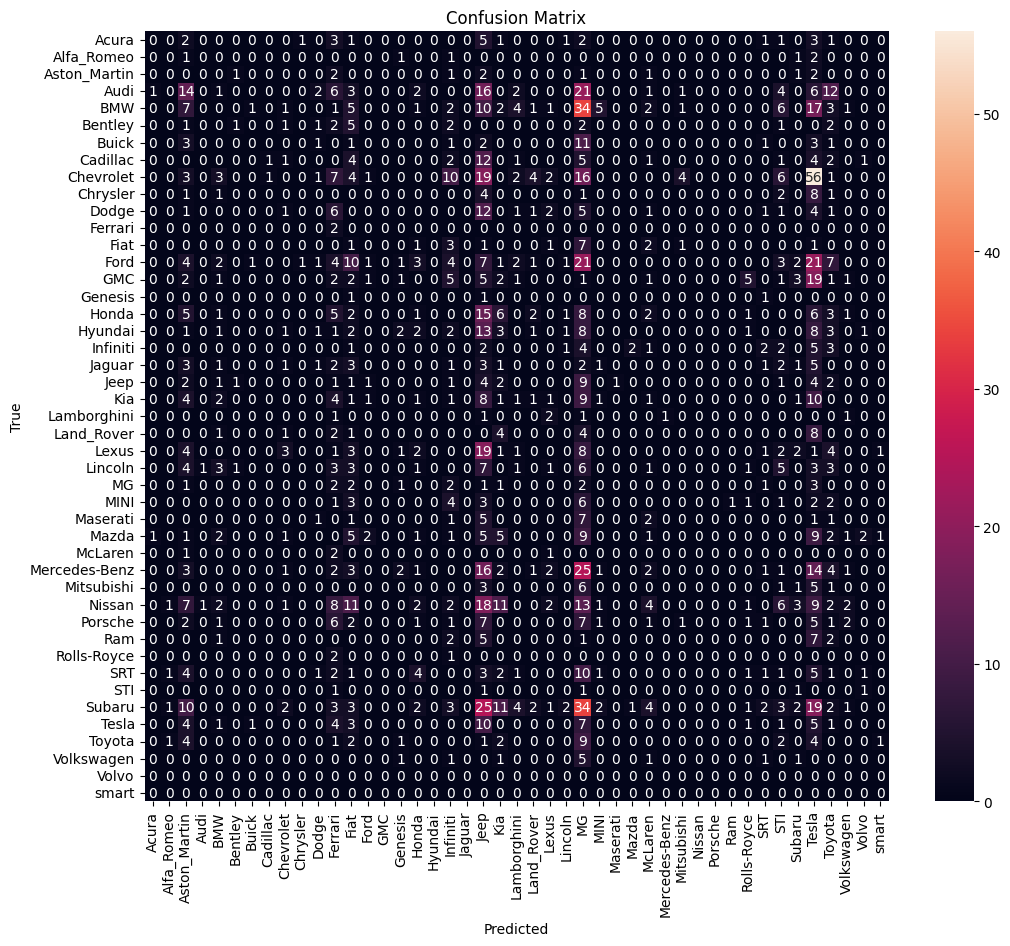

In [24]:
# Test the model

print("\nEvaluating on test set...")
model.eval()
correct = 0
total = 0
test_start = time.time()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Extract logits from outputs if needed - Hugging Face models return objects with logits attribute
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        _, preds = torch.max(logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_time = time.time() - test_start
print(f"Test completed in {test_time:.2f} seconds")
print("Unique labels:", np.unique(all_labels))
print("Unique predictions:", np.unique(all_preds))
#print(f'Accuracy on test set: {100 * correct / total:.2f}%')

# Print final DirectML device information
print("\nDirectML GPU Usage Information:")
print(f"Device Name: {dml.device_name(dml.default_device())}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test 1

Loading model...


C:\Users\lalad\AppData\Local\Temp\ipykernel_20928\1041079170.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./best_resnet_car_classifier.pth'


Testing with a random image:
Selected image: Toyota_Prius_2019_23_15_120_18_4_69_57_180_54_FWD_5_4_4dr_DGH.jpg


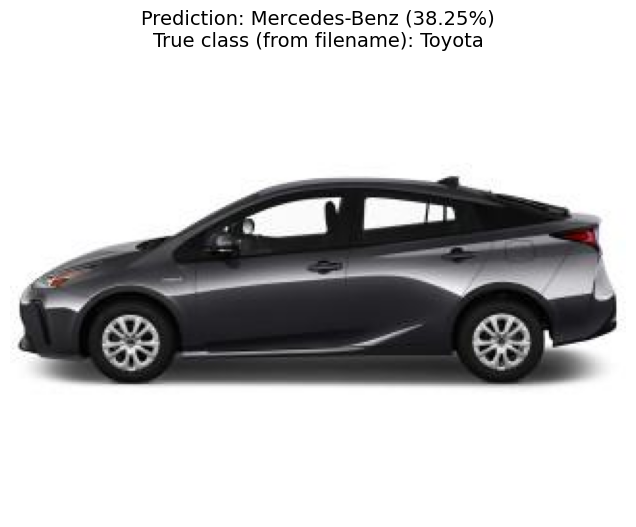

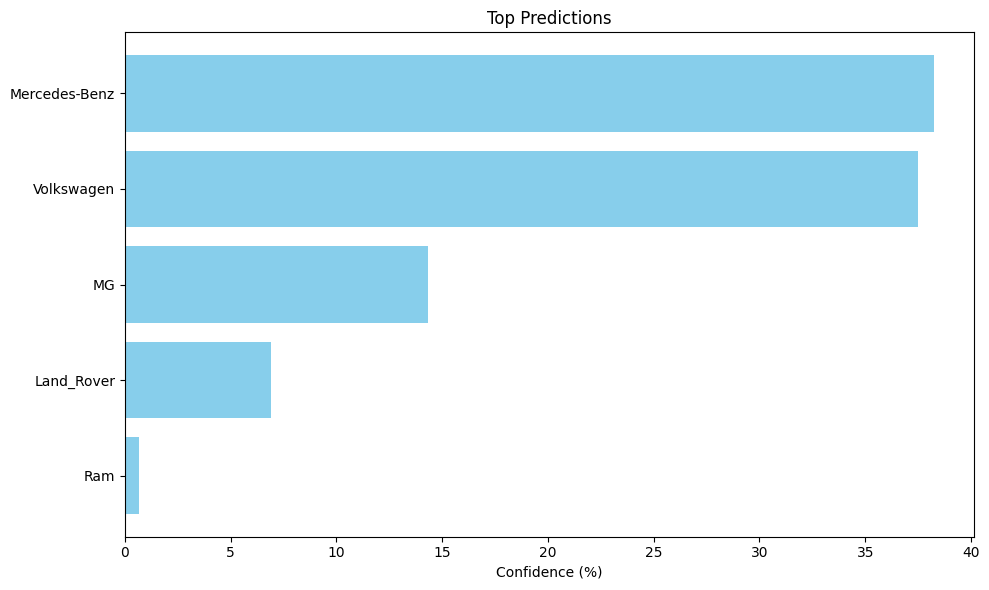


Testing with multiple random images:
Class names length: 45
Model output size: 48
This will cause index errors when predictions are out of range


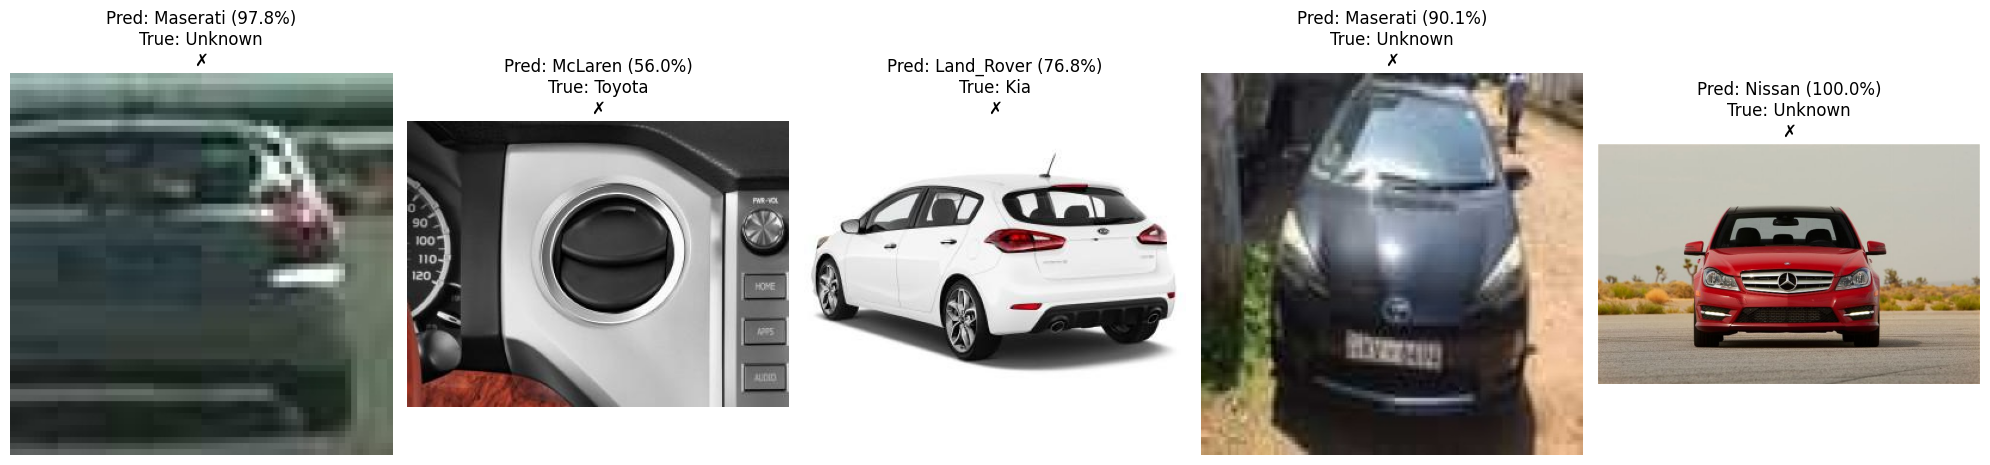

In [62]:
def test_with_random_image(model, class_names, device, data_dir='./images/cars', test_transform=None):
    """Test the model with a random car image"""
    # Get a random image from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    img_file = random.choice(image_files)
    img_path = os.path.join(data_dir, img_file)
    print(f"Selected image: {img_file}")
    
    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(image).unsqueeze(0).to(device)
    
    # Try to determine true label from filename
    true_class = "Unknown"
    for make in top_makes:
        if make.lower() in img_file.lower():
            true_class = make
            break
    
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        # Extract logits from output object
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
        probs = torch.nn.functional.softmax(logits, dim=1)[0]
        _, pred_idx = torch.max(logits, 1)
    
    # Get prediction results
    pred_class = class_names[pred_idx.item()]
    confidence = probs[pred_idx.item()].item() * 100
    
    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)\nTrue class (from filename): {true_class}", fontsize=14)
    plt.show()
    
    # Get top 5 predictions
    top_k = min(5, len(class_names))
    top_probs, top_idx = torch.topk(probs, top_k)
    top_classes = [class_names[idx.item()] for idx in top_idx]
    top_confidences = [prob.item() * 100 for prob in top_probs]
    
    # Show top predictions
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_k), top_confidences, color='skyblue')
    plt.yticks(range(top_k), top_classes)
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    plt.gca().invert_yaxis()  # Highest confidence at the top
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, true_class

# Test multiple random images
def test_multiple_random_images(model, class_names, device, data_dir='./images/cars', 
                               test_transform=None, num_images=5):
    """Test model with multiple random images with error handling for class index mismatches"""
    # Get random images from the directory
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print(f"No image files found in {data_dir}")
        return
    
    # Check model output size vs class_names
    print(f"Class names length: {len(class_names)}")
    # Check model output size by getting the final layer's output dimension
    output_size = model.fc.out_features if hasattr(model, 'fc') else None
    print(f"Model output size: {output_size}")
    if output_size and output_size != len(class_names):
        print(f"WARNING: Model output size ({output_size}) doesn't match class_names length ({len(class_names)})")
        print("This will cause index errors when predictions are out of range")
    
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(random_images), figsize=(20, 5))
    if len(random_images) == 1:
        axes = [axes]
    
    results = []
    
    # Process each image
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(data_dir, img_file)
        
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(image).unsqueeze(0).to(device)
        
        # Try to determine true class
        true_class = "Unknown"
        for make in top_makes:
            if make.lower() in img_file.lower():
                true_class = make
                break

        with torch.no_grad():
            outputs = model(img_tensor)
            # Extract logits from output object
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
            probs = torch.nn.functional.softmax(logits, dim=1)[0]
            _, pred_idx = torch.max(logits, 1)
            
            # Get prediction details for debugging
            predicted_index = pred_idx.item()
            confidence = probs[predicted_index].item() * 100
            
        # Safely get predicted class name
        try:
            pred_class = class_names[predicted_index]
        except IndexError:
            print(f"WARNING: Predicted index {predicted_index} is out of range for class_names list (length {len(class_names)})")
            pred_class = f"Unknown (idx={predicted_index})"
        
        # Display image with prediction
        axes[i].imshow(image)
        axes[i].axis('off')
        correct = "✓" if pred_class.replace('_', ' ') == true_class else "✗"
        axes[i].set_title(f"Pred: {pred_class} ({confidence:.1f}%)\nTrue: {true_class}\n{correct}")
        
        results.append((pred_class, confidence, true_class))
    
    plt.tight_layout()
    plt.show()
    return results

# Load the trained model
print("Loading model...")
checkpoint = torch.load('./best_resnet_car_classifier.pth')
#num_classes = 48  # As indicated by the error message - the checkpoint has 48 classes
num_classes = model.fc.out_features  # For ResNet models
class_names = image_datasets['train'].classes
model = models.resnext101_32x8d(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
model.load_state_dict(torch.load('./best_resnet_car_classifier.pth'))

# Test with a single random image
print("\nTesting with a random image:")
pred_class, confidence, true_class = test_with_random_image(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test']
)

# Test with multiple random images
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    num_images=5
)

test 2


Testing with multiple random images:
Class names length: 45
Model output size: 48
This will cause index errors when predictions are out of range


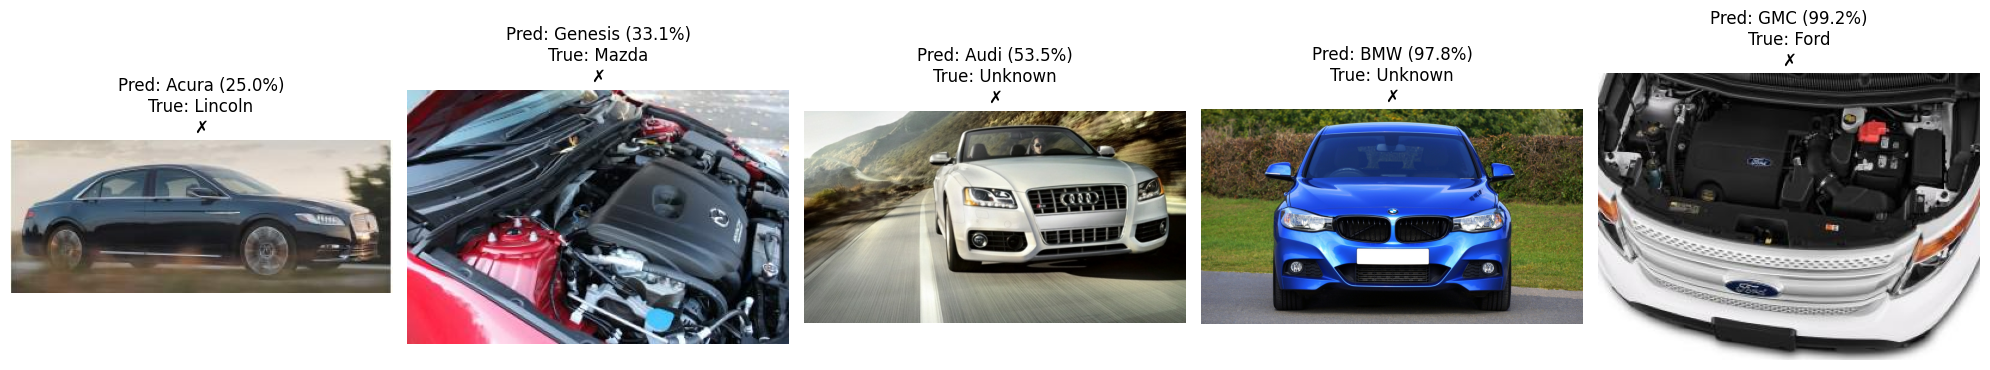

In [91]:
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    num_images=5,
    data_dir='./images/cars'
)


Testing with multiple random images:
Class names length: 45
Model output size: 48
This will cause index errors when predictions are out of range


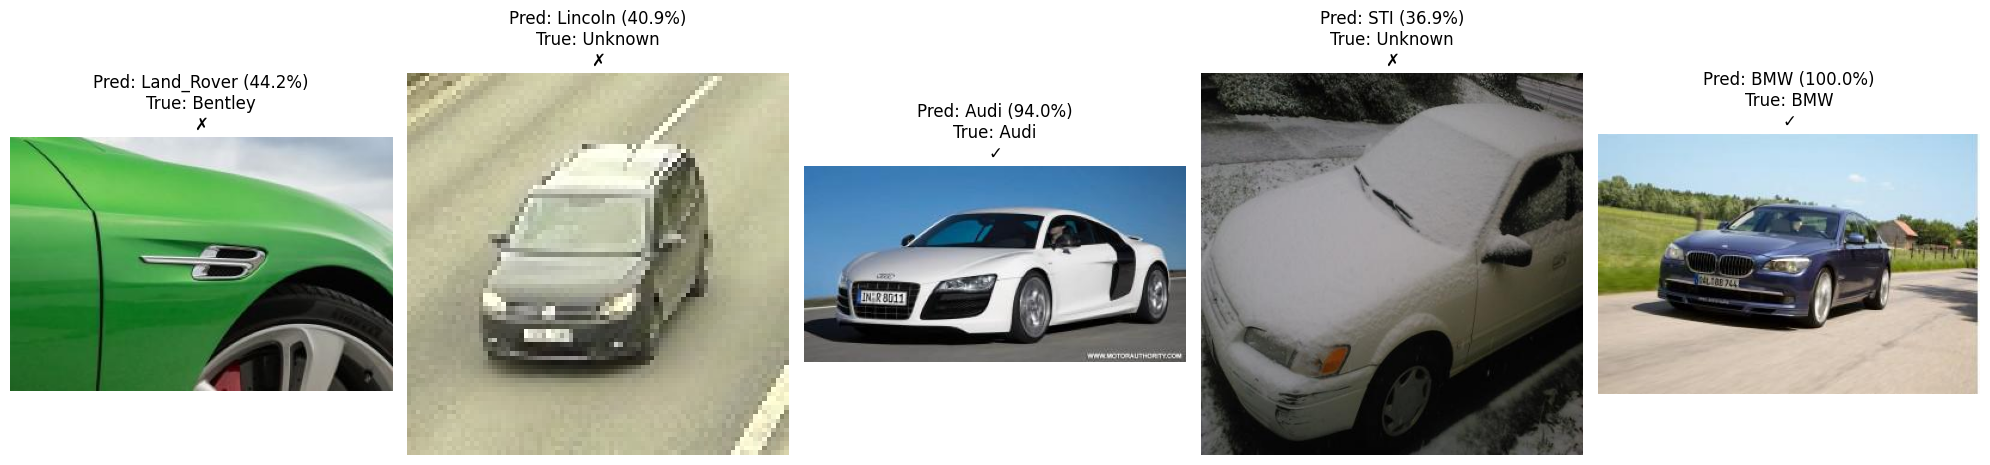

In [109]:
print("\nTesting with multiple random images:")
results = test_multiple_random_images(
    model=model,
    class_names=class_names,
    device=device,
    test_transform=data_transforms['test'],
    num_images=5,
    data_dir='./images/cars'
)